## Importación de librerías y definición de funciones

In [1]:
# importar librerías
import pandas as pd
import nums_from_string
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
import nums_from_string
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

################# extrae los links de la página Rightmove ####################

def get_links_Rightmove():
    ser = Service("./chromedriver")
    options = Options()
    options.headless = True
    options.add_argument("--window-size=1920,1200")
    links = []
    driver = webdriver.Chrome(options=options, service=ser)
    driver.get("https://www.rightmove.co.uk/property-to-rent/find.html?searchType=RENT&locationIdentifier=REGION%5E87490&insId=1&radius=0.0&minPrice=&maxPrice=&minBedrooms=&maxBedrooms=&displayPropertyType=&maxDaysSinceAdded=&sortByPriceDescending=&_includeLetAgreed=on&primaryDisplayPropertyType=&secondaryDisplayPropertyType=&oldDisplayPropertyType=&oldPrimaryDisplayPropertyType=&letType=&letFurnishType=&houseFlatShare=")
    for i in range(3): #cada iteración son 25 links
        apts_links = driver.find_elements(By.CLASS_NAME, "propertyCard-details")
        for a in apts_links:
            links.append(a.find_element(By.CLASS_NAME, "propertyCard-link").get_attribute('href'))
        nb = driver.find_element(By.XPATH, "//button[contains(@class, 'pagination-button pagination-direction pagination-direction--next')]")
        nb.click()
        time.sleep(2)
    df = pd.DataFrame(links)
    df = df.rename(columns={0: 'urls'})
    df.to_csv('urls_rightmove.csv')    # se guardan en un excel los archivos
    driver.quit()
    print('DONE')
    return

################# Recopila los precios de las habitaciones en London ####################

def get_precios_London():
    inicio = time.time()
    prop_dict_list = []
    
    df = pd.read_csv('urls_rightmove.csv')
    options = Options()
    options.headless = True
    options.add_argument("--window-size=1920,1200")
    driver = webdriver.Chrome('./chromedriver_mac64/chromedriver', options=options)
    
    for i in df['urls']:
        prop_dict = {}
        page = driver.get(i)
        precio_class = driver.find_element(By.CLASS_NAME, '_1gfnqJ3Vtd1z40MlC0MzXu')
        precio_span = precio_class.find_element(By.XPATH, 'span')        
        precio_str = precio_span.text
        precio_str = precio_str.replace('.', '').replace(',', '')
        precio_pounds = precio_str[1:-3]    #se elimina los datos que no se necesita
        hay_precio = 1
        hay_tamanho = 1
        #Se utiliza Try para no detener la ejecución
        try:
            # Se ejecutan las siguientes líneas de código para extraer solo los números
            precio_euros = float(precio_pounds)*1.14  # en una de las pestañas el precio era solo letras sin nros(publicidad)
                                                      # por eso evalúa si hay error en float()
        except:
            hay_precio = 0
        try:
            tag = driver.find_element(By.XPATH,"//*[contains(@class,'_3vyydJK3KMwn7-s2BEXJAf')]")
        except:
            hay_tamanho = 0
        else:
            palabra = tag.text[1:-7]            #se elimina los datos que no se necesita
            palabra = palabra.replace(',', '')
            if (len(palabra)>=5):
                sep = palabra.split("-")
                palabra = sep[1]
            # Se ejecutan las siguientes líneas de código para extraer solo los números
            sqmeters = float(palabra)
            precio_x_metro = precio_euros/sqmeters
            prop_dict['London'] = precio_x_metro
            if (hay_precio and hay_tamanho):            #si no hay datos válidos, no se guarda en el dataframe
                prop_dict_list.append(prop_dict)         
        time.sleep(1)
    df = pd.DataFrame(prop_dict_list)
    df.to_csv('Precios_London.csv')
    driver.quit()
    fin = time.time()
    print('DONE')
    print('Tiempo:',(fin-inicio)//60,'minutos y',round((fin-inicio)%60) ,'segundos')
    return df

################# extrae los links de la página Badi ####################

def get_links_Badi():
    ser = Service("./chromedriver")
    options = Options()
    options.headless = True
    options.add_argument("--window-size=1920,1200")
    links = []
    driver = webdriver.Chrome(options=options, service=ser)
    driver.get("https://badi.com/es/s/Barcelona--Espa%C3%B1a?bounds=41.4682974272428,2.22804492421789;41.31703848925413,2.052333262952554&center=41.3873974,2.168568&d=11.164609446567885&city=Barcelona&pid=ChIJ5TCOcRaYpBIRCmZHTz37sEQ&z=12")
    for i in range(2): #cada iteración son 20 links
        enlaces = driver.find_elements(By.XPATH,"//a[contains(@data-qa, 'room-card-link')]")
        for a in enlaces:
            links.append(a.get_attribute('href')) 
        nb = driver.find_element(By.XPATH, "//button[contains(@class, 'sc-9fxd19-1 jEzqfk')]")
        nb.click()
        time.sleep(2)
    df = pd.DataFrame(links)
    df = df.rename(columns={0: 'urls'})
    df.to_csv('urls_badi.csv')              # se guardan en un excel los archivos
    driver.quit()
    print('DONE')
    return

################# Recopila los precios de las habitaciones en Barcelona ####################

def get_precios_Barcelona():
    inicio = time.time()
    prop_dict_list = []    
    df = pd.read_csv('urls_badi.csv')
    options = Options()
    options.headless = True
    options.add_argument("--window-size=1920,1200")
    driver = webdriver.Chrome('./chromedriver_mac64/chromedriver', options=options)
    for i in df['urls']:
        prop_dict = {}
        dato_valido = 1
        page = driver.get(i)
        #Se utiliza Try para no detener la ejecución
        try: 
            tamanho_html = driver.find_element(By.XPATH,"//p[contains(@data-qa, 'section-abstract-icon-label-area')]").text
            precio_html = driver.find_element(By.XPATH,"//h4[contains(@data-qa, 'room-details-current-price')]").text
        except:
            dato_valido=0
        
         # Se ejecutan las siguientes líneas de código para extraer solo los números
        tamanho_float = float(tamanho_html[:-2])   #se elimina los datos que no se necesita
        precio_str = precio_html[:-4]              #se elimina los datos que no se necesita
        precio_float = float(precio_str.replace('.', '').replace(',', '').replace('€', ''))
        if(tamanho_float > 0):
            precio_x_metro = precio_float/tamanho_float
            prop_dict['Barcelona'] = precio_x_metro
            if (dato_valido):            #si no hay datos, no se guarda en el dataframe
                prop_dict_list.append(prop_dict)
        time.sleep(1)
    df = pd.DataFrame(prop_dict_list)
    df.to_csv('Precios_Barcelona.csv')
    driver.quit()
    fin = time.time()
    print('DONE')
    print('tiempo:',(fin-inicio)//60,'minutos y',round((fin-inicio)%60) ,'segundos')
    return df

################# Plotea el promedio de precios de las ciudades ingresadas ####################

def Ploting_Comparison(df_london, df_bcn):
    df_london = pd.read_csv('Precios_London.csv',index_col = [0])
    df_bcn = pd.read_csv('Precios_Barcelona.csv',index_col = [0])
    cant_london = df_london.shape[0]                                     #cantidad datos london
    cant_barcelona= df_bcn.shape[0]                                      #cantidad datos barcelona
    average_London = df_london.London.mean()                      
    average_Barcelona = df_bcn.Barcelona.mean()
    Cities = ['London','Barcelona']
    Avg_price = [round(average_London,2), round(average_Barcelona,2)]
    df = pd.DataFrame({'Cities': Cities, 'Avg_price': Avg_price})        #se crea dataframe con datos de ambas ciudades
    plt.title('Average of renting a room in London and Barcelona')
    ax = sns.barplot(data = df, x=Cities, y = Avg_price)                 #se plotea los graficos
    ax.bar_label(ax.containers[0], fmt='%.2f € / m2')
    print(f'Para la ciudad de London se promediaron {cant_london} y para Barcelona {cant_barcelona} habitaciones')
    return
    

## Se extraen los links 

In [2]:
get_links_Rightmove()
get_links_Badi()

DONE
DONE


## Recopilación de precios de la ciudad de London

In [3]:
London = get_precios_London()

C:\Users\ockda\AppData\Local\Temp\ipykernel_19780\528116549.py:48: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver_mac64/chromedriver', options=options)


DONE
Tiempo: 3.0 minutos y 3 segundos


## Recopilación de precios de la ciudad de Barcelona

In [4]:
Barcelona = get_precios_Barcelona()

C:\Users\ockda\AppData\Local\Temp\ipykernel_19780\528116549.py:125: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver_mac64/chromedriver', options=options)


DONE
tiempo: 2.0 minutos y 16 segundos


## Ploteo de resultados

Para la ciudad de London se promediaron 28 y para Barcelona 38 habitaciones


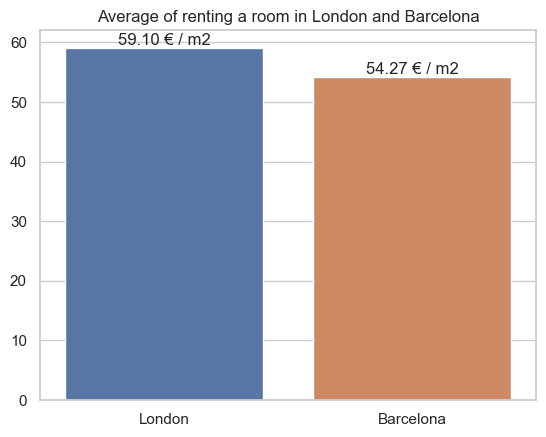

In [5]:
Ploting_Comparison(London, Barcelona)